# Super Ellipsoid Fit to a Capsicum ROI PointCloud

**Salih Marangoz**

Implemented the idea in "Sweet pepper pose detection and grasping for automated crop harvesting". 

**Note:** Ideas of "Estimating center with normals" and "Cost Function based on Radial Euclidian Distance" are not implemented here!

- Paper: https://eprints.qut.edu.au/95756/

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib notebook

In [2]:
def c_func(w,m):
    return np.sign(np.cos(w)) * np.abs(np.cos(w))**m

def s_func(w,m):
    return np.sign(np.sin(w)) * np.abs(np.sin(w))**m

# superellipsoid -> x,y,z : https://en.wikipedia.org/wiki/Superellipsoid
def superellipsoid_to_xyz(A=1,B=1,C=1,E1=0.5,E2=0.3,custom_args=None):
    if custom_args is None:
        v = np.linspace(-np.pi/2, np.pi/2, 30)
        u = np.linspace(-np.pi, np.pi, 50)
    else:
        v = np.linspace(custom_args["v_min"], custom_args["v_max"], custom_args["v_count"])
        u = np.linspace(custom_args["u_min"], custom_args["u_max"], custom_args["u_count"])
    uu, vv = np.meshgrid(u,v)
    
    #r = 2    # from wikipedia
    #t = 2.5  # from wikipedia
    r = 2/E2  # from the paper
    t = 2/E1  # from the paper
    
    x = A * c_func(vv, 2/t) * c_func(uu, 2/r)
    y = B * c_func(vv, 2/t) * s_func(uu, 2/r)
    z = C * s_func(vv, 2/t)
    
    return x,y,z

<IPython.core.display.Javascript object>


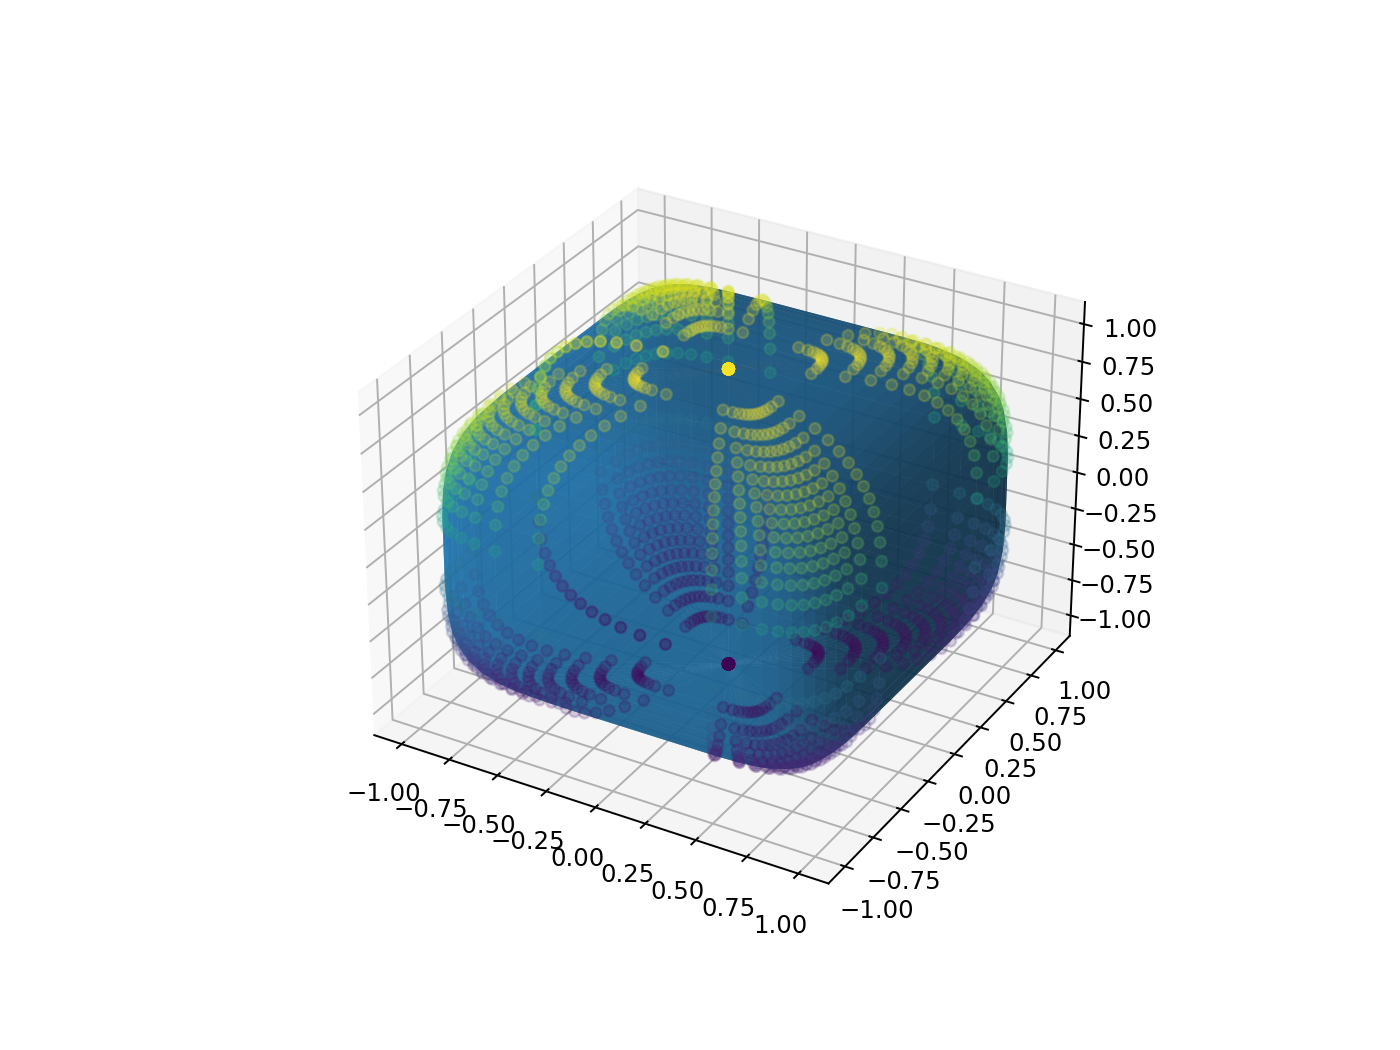

In [4]:
x,y,z = superellipsoid_to_xyz()

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(projection='3d')              
ax.plot_surface(x, y, z, alpha=0.75)
_=ax.scatter(x, y, z, c=z, alpha=0.2)

In [5]:
from scipy.spatial.transform import Rotation as R

def rotate_xyz(x,y,z,roll,pitch,yaw):
    datashape = x.shape
    r = R.from_rotvec(np.array([roll, pitch, yaw]))
    xyz = r.apply(np.array([x.flatten(),y.flatten(),z.flatten()]).T)
    x,y,z = xyz.T
    return x.reshape(datashape), y.reshape(datashape), z.reshape(datashape)

def translate_xyz(x,y,z,Tx,Ty,Tz):
    x += Tx
    y += Ty
    z += Tz
    return x,y,z

<IPython.core.display.Javascript object>


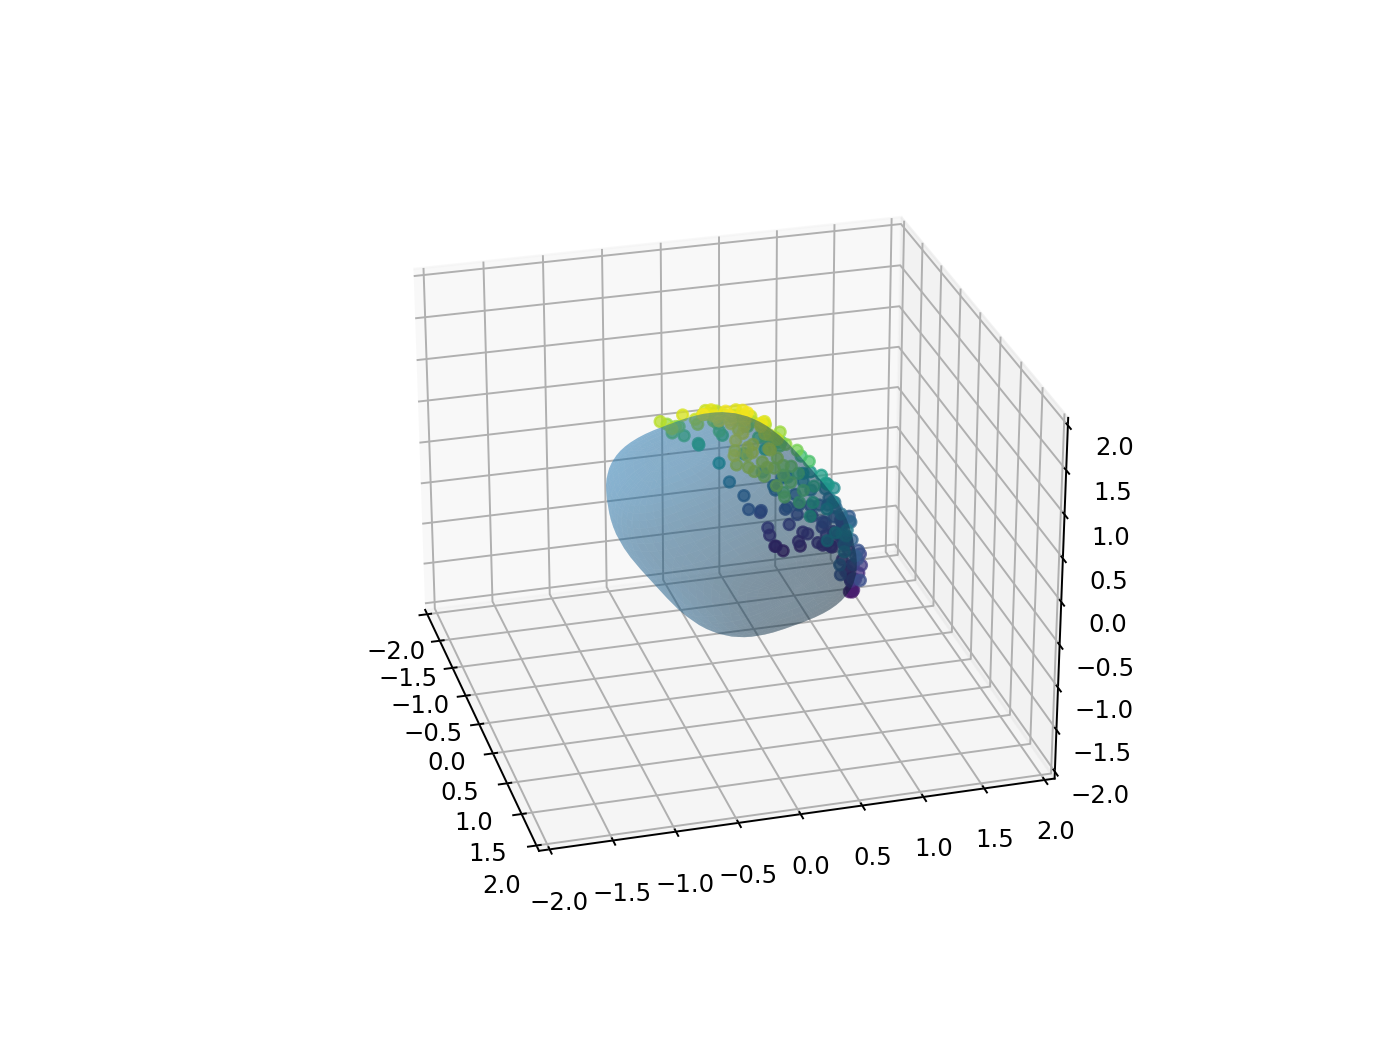

(-2.0, 2.0)

In [6]:
# generate data:

# PARAMETERS
A,B,C = 0.8 , 0.8 , 1.1
E1,E2 = 0.6 , 0.7
roll,pitch,yaw = 0.5,0.1,-0.2
Tx, Ty, Tz = 0.1, 0.0, 0.0
custom_args = {"v_min": -np.pi/3, "v_max": np.pi/3, "v_count": 20,
               "u_min": np.pi/3, "u_max": np.pi, "u_count": 10}

x, y, z = superellipsoid_to_xyz(A,B,C,E1,E2)
x, y, z = rotate_xyz(x,y,z,roll,pitch,yaw)
x, y, z = translate_xyz(x, y, z,Tx, Ty, Tz)

x_, y_, z_ = superellipsoid_to_xyz(A,B,C,E1,E2,custom_args=custom_args)
x_, y_, z_ = rotate_xyz(x_,y_,z_,roll,pitch,yaw)
x_, y_, z_ = translate_xyz(x_, y_, z_,Tx, Ty, Tz)

x_ += 0.05*np.random.normal(size=x_.shape)
y_ += 0.03*np.random.normal(size=y_.shape)
z_ += 0.03*np.random.normal(size=z_.shape)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(projection='3d')              
ax.plot_surface(x, y, z, alpha=0.3)
_=ax.scatter(x_.flatten(), y_.flatten(), z_.flatten(), c=z_.flatten(), alpha=0.75)
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_zlim(-2, 2)

In [7]:
def loss(x0,x,y,z):
    a,b,c,e1,e2,tx,ty,tz,yaw,pitch,roll = x0
    
    # https://otik.uk.zcu.cz/bitstream/11025/1637/1/D71.pdf
    x,y,z = rotate_xyz(x,y,z,roll,pitch,yaw)
    x,y,z = translate_xyz(x,y,z,tx,ty,tz)
    
    #x,y,z = x+0j, y+0j, z+0j
    x,y,z = np.abs(x), np.abs(y), np.abs(z)
    
    f = ( (x/a)**(2/e2) + (y/b)**(2/e2) )**(e2/e1) + (z/c)**(2/e1)
    #f = (np.sqrt(a*b*c) * (f**e1 - 1.))**2
    f = np.abs(a*b*c) * (f**e1 - 1.)**2
    
    # additions: (MAYBE? OR ADD THESE AS A CONSTRAINT)
    #f += 0.001*np.abs(tx + ty + tz)
    #f += 0.001*np.abs(roll+pitch+yaw)
    #f += 0.001*(a-1)
    #f += 0.001*(b-1)
    #f += 0.001*(c-1)

    #f = np.sum(f)
    #f = np.linalg.norm(f)
    #print(f)
    return f

A:0.843961622361953,B:0.766788320451414,C:1.0308340008637544,E1:0.4739664879098191,E2:0.7023025340646515,tx:-0.12667918127492403,ty:-0.046254401721850504,tz:-0.0054096454380868336,yaw:0.2219024860564491,pitch:-0.10299494054227519,roll:-0.5008263294544505


<IPython.core.display.Javascript object>


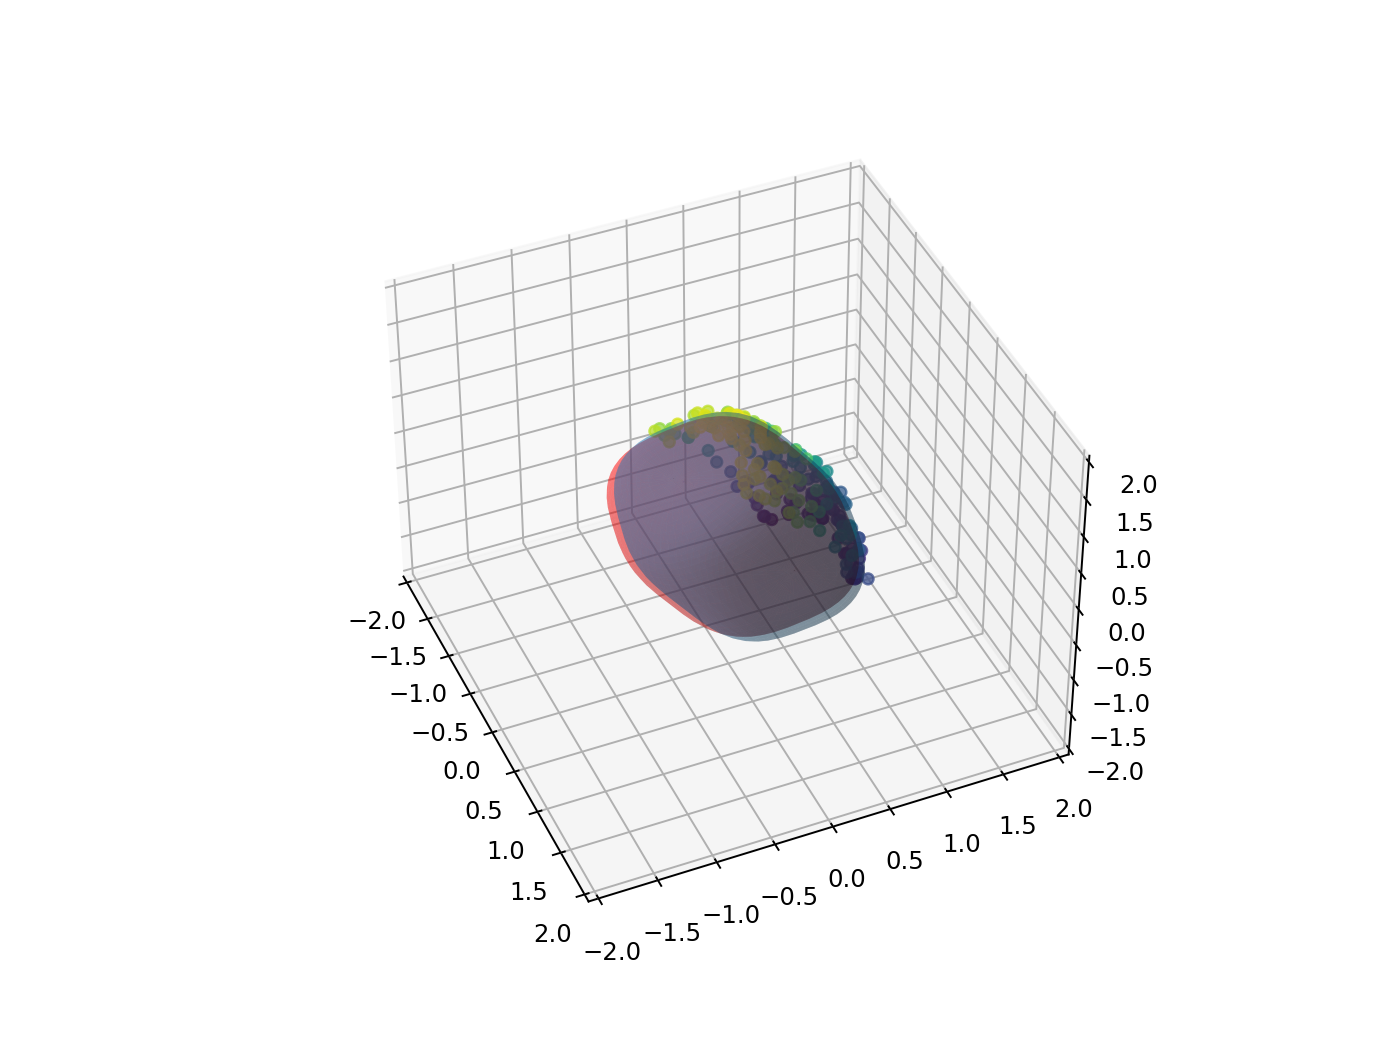

In [8]:
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html#scipy.optimize.least_squares

# OPTIMIZE
from scipy.optimize import least_squares
x0 = (1,1,1,0.7,0.7,0,0,0,0,0,0)
result = least_squares(loss, x0, args=(x_.flatten(), y_.flatten(), z_.flatten()), method="lm")
#print(result)
A,B,C,E1,E2,tx,ty,tz,yaw,pitch,roll = result["x"]
print("A:{},B:{},C:{},E1:{},E2:{},tx:{},ty:{},tz:{},yaw:{},pitch:{},roll:{}".format(A,B,C,E1,E2,tx,ty,tz,yaw,pitch,roll))

# CALCULATE SUPERELLIPSOID
xr, yr, zr = superellipsoid_to_xyz(A,B,C,E1,E2,custom_args=None)
xr, yr, zr = rotate_xyz(xr, yr, zr,-roll,-pitch,-yaw)
xr, yr, zr = translate_xyz(xr, yr, zr,-tx,-ty,-tz)

# PLOT
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(projection='3d')  
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_zlim(-2, 2)
ax.plot_surface(xr, yr, zr, alpha=0.3)
ax.plot_surface(x, y, z, alpha=0.3, color="red") # GT
_=ax.scatter(x_, y_, z_, c=z_, alpha=0.75)